# Stock Price Forecast using LSTM

# Import libraries

In [23]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import yfinance as yf
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import statsmodels.api as sm
from tqdm import tqdm
from scipy import signal
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import IsolationForest
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

# Set variables

In [24]:
# Set variables
ticker = 'DIS'
start_date = '2018-04-02'
end_date = '2023-04-02'
interval = '1d'
data_col = 'Close'

# Import data

In [25]:
# Download stock price from Yahoo Finance
stock_price = yf.download(ticker, start=start_date, end=end_date, interval=interval)[data_col]
stock_price = pd.DataFrame(stock_price)
stock_price.head()

[*********************100%***********************]  1 of 1 completed


,Close
Date,
2018-04-02,98.660004
2018-04-03,99.419998
2018-04-04,100.949997
2018-04-05,102.110001
2018-04-06,100.349998


# Stock data analysis

## Check missing value

In [26]:
# Check null
stock_price.isnull().sum()

Close    0
dtype: int64

Stock price has no missing values

## Plot stock price

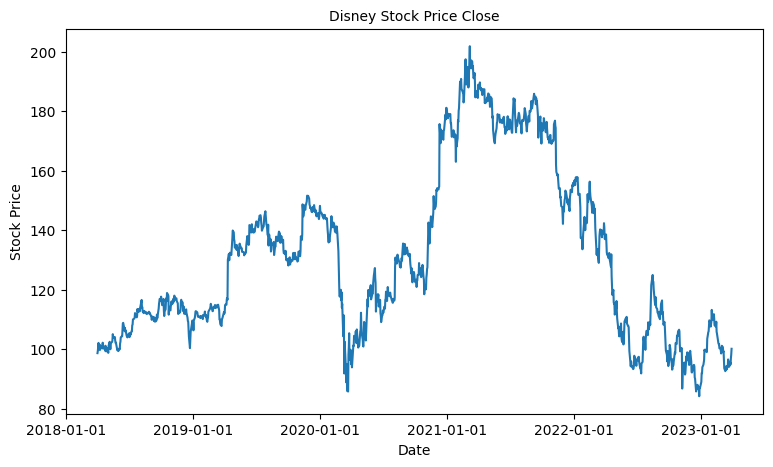

In [27]:
# Create the plot
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(stock_price.index, stock_price.values)

# Format the x-axis ticks to show the full date
date_fmt = '%Y-%m-%d'
ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter(date_fmt))

# Set labels and title
ax.set_xlabel('Date', size=10)
ax.set_ylabel('Stock Price', size=10)
ax.set_title('Disney Stock Price Close', size=10)

# Display the plot
plt.show()

The raw data in the stock price close data exhibits a certain pattern. Despite a decrease at the beginning of Q1 2020, there is a general upward trend and again downward trend from the middle of 2021 

## Scale stock price

In [28]:
# Normalize the data
sc = MinMaxScaler(feature_range=(-1, 1))
stock_price['Close'] = sc.fit_transform(stock_price['Close'].values.reshape(-1, 1))
stock_price_scaled = stock_price
stock_price.head()

,Close
Date,
2018-04-02,-0.753864
2018-04-03,-0.740955
2018-04-04,-0.714965
2018-04-05,-0.695261
2018-04-06,-0.725157


# Split Train/Test data

In [7]:
# Train/Test split
split_ratio = 0.8
split_pos = int(split_ratio*len(stock_price))

train_set = stock_price.iloc[:split_pos].values
test_set = stock_price.iloc[split_pos:].values

# Prepare Test/Train dataset

## Custom dataset class

In [8]:
# Custom dataset
class Stock_Dataset(Dataset):
  def __init__(self, data, seq_len):
    self.data = data
    self.seq_len = seq_len

  def __len__(self):
    return len(self.data) - self.seq_len #-1

  def __getitem__(self, index):
    # Create sequence for LSTM model
    x_seq = self.data[index:index+self.seq_len]
    y_seq = self.data[index+self.seq_len]
    # Return tensors
    return torch.tensor(x_seq).float(), torch.tensor(y_seq).float()

## Test/Train dataset & data loader

In [9]:
seq_len = 16
batch_size = 16

# Create train/test dataset
train_dataset = Stock_Dataset(train_set, seq_len)
test_dataset = Stock_Dataset(test_set, seq_len)

# Create train/test data loader
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

# Build LSTM model

## Design LSTM model

In [10]:
class LSTM_Forecast(nn.Module):
  def __init__(self, input_size=1, hidden_size=30, output_size=1, lstm_layers=1):
    super(LSTM_Forecast, self).__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.output_size = output_size
    self.lstm_layers = lstm_layers

    # Create LSTM layer
    self.lstm = nn.LSTM(input_size, hidden_size, lstm_layers)
    # Create fully connected layer
    self.linear = nn.Linear(hidden_size, output_size)
      
  def forward(self, input):
    # Define states
    h_st = torch.zeros(self.lstm_layers, input.size(1), self.hidden_size)         # LSTM hidden state
    c_st = torch.zeros(self.lstm_layers, input.size(1), self.hidden_size)         # LSTM cell state
    
    # Outputs
    out, (hn, cn) = self.lstm(input, (h_st, c_st))
    out = self.linear(out[-1])
    
    return out

## Model summary

In [11]:
# Initialize model
model = LSTM_Forecast()
model

LSTM_Forecast(
  (lstm): LSTM(1, 30)
  (linear): Linear(in_features=30, out_features=1, bias=True)
)

# Train model

## Define hyperparameters

In [12]:
# Check device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Hyperparameters
learning_rate = 5e-5
epochs = 100
criterion = nn.MSELoss().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

## Training statistics

In [13]:
pbar = tqdm(range(epochs))

# Train/validation losses
train_total_loss = []
test_total_loss = []

# Train and evaluate model
for epoch in pbar:
  train_loss = 0
  test_loss = 0

  # Set the model to training state
  model.train()                                                                                                             

  # Train the model on the train dataset
  for i, (inputs, targets) in enumerate(train_dataloader):
    optimizer.zero_grad()

    inputs = inputs.to(device)
    targets = targets.squeeze().to(device)

    # Forward pass
    tr_outputs = model(inputs).squeeze()
    tr_loss = criterion(tr_outputs, targets)
    train_loss += tr_loss.item()
    tr_loss.backward()
    optimizer.step()

  # Calculate total training loss
  tr_epoch_loss = train_loss/len(train_dataloader)
  train_total_loss.append(tr_epoch_loss)

  # Set the model to evaluation mode
  model.eval()

  # Evaluate the model on the test dataset
  for i, (inputs, targets) in enumerate(test_dataloader):
    with torch.no_grad():
      inputs = inputs.to(device)
      targets = targets.squeeze().to(device)

      te_outputs = model(inputs).squeeze()
      te_loss = criterion(te_outputs, targets)
    
    test_loss += te_loss.item()
        
  # Calculate total test loss
  te_epoch_loss = test_loss/len(test_dataloader)
  test_total_loss.append(te_epoch_loss)

  # Print stats at each epoch
  if(epoch%1 == 0):
    pbar.set_description(f"Epoch {epoch+1}/{epochs} \t")
    print(f'Train Loss: {tr_loss.item():.4f}, Test Loss: {te_loss.item():.4f}')

Epoch 2/100 	:   2%|▏         | 2/100 [00:00<00:27,  3.62it/s]

Train Loss: 0.3697, Test Loss: 0.3613
Train Loss: 0.2190, Test Loss: 0.3800


Epoch 4/100 	:   4%|▍         | 4/100 [00:00<00:21,  4.50it/s]

Train Loss: 0.2247, Test Loss: 0.3711
Train Loss: 0.1778, Test Loss: 0.3622


Epoch 5/100 	:   5%|▌         | 5/100 [00:01<00:19,  4.79it/s]

Train Loss: 0.3619, Test Loss: 0.4073


Epoch 6/100 	:   6%|▌         | 6/100 [00:01<00:23,  4.08it/s]

Train Loss: 0.1792, Test Loss: 0.3831


Epoch 7/100 	:   7%|▋         | 7/100 [00:01<00:28,  3.28it/s]

Train Loss: 0.1788, Test Loss: 0.3373


Epoch 8/100 	:   8%|▊         | 8/100 [00:02<00:31,  2.89it/s]

Train Loss: 0.2182, Test Loss: 0.4270


Epoch 9/100 	:   9%|▉         | 9/100 [00:03<00:44,  2.06it/s]

Train Loss: 0.2212, Test Loss: 0.3783


Epoch 10/100 	:  10%|█         | 10/100 [00:03<00:50,  1.78it/s]

Train Loss: 0.2918, Test Loss: 0.4280


Epoch 11/100 	:  11%|█         | 11/100 [00:04<00:42,  2.11it/s]

Train Loss: 0.1996, Test Loss: 0.3498


Epoch 12/100 	:  12%|█▏        | 12/100 [00:04<00:36,  2.41it/s]

Train Loss: 0.2820, Test Loss: 0.2938


Epoch 13/100 	:  13%|█▎        | 13/100 [00:04<00:31,  2.74it/s]

Train Loss: 0.2019, Test Loss: 0.4685


Epoch 15/100 	:  15%|█▌        | 15/100 [00:05<00:23,  3.61it/s]

Train Loss: 0.1864, Test Loss: 0.3753
Train Loss: 0.2768, Test Loss: 0.3880


Epoch 17/100 	:  17%|█▋        | 17/100 [00:05<00:19,  4.24it/s]

Train Loss: 0.2349, Test Loss: 0.3366
Train Loss: 0.2702, Test Loss: 0.4426


Epoch 19/100 	:  19%|█▉        | 19/100 [00:05<00:17,  4.67it/s]

Train Loss: 0.2673, Test Loss: 0.2830
Train Loss: 0.2161, Test Loss: 0.3443


Epoch 21/100 	:  21%|██        | 21/100 [00:06<00:15,  4.98it/s]

Train Loss: 0.1973, Test Loss: 0.3661
Train Loss: 0.1824, Test Loss: 0.3304


Epoch 23/100 	:  23%|██▎       | 23/100 [00:06<00:14,  5.16it/s]

Train Loss: 0.1602, Test Loss: 0.3194
Train Loss: 0.2308, Test Loss: 0.3993


Epoch 25/100 	:  25%|██▌       | 25/100 [00:06<00:14,  5.26it/s]

Train Loss: 0.2912, Test Loss: 0.3732
Train Loss: 0.1025, Test Loss: 0.2847


Epoch 27/100 	:  27%|██▋       | 27/100 [00:07<00:13,  5.34it/s]

Train Loss: 0.3059, Test Loss: 0.2729
Train Loss: 0.3067, Test Loss: 0.3041


Epoch 29/100 	:  29%|██▉       | 29/100 [00:07<00:13,  5.29it/s]

Train Loss: 0.2154, Test Loss: 0.3063
Train Loss: 0.2673, Test Loss: 0.3512


Epoch 31/100 	:  31%|███       | 31/100 [00:08<00:13,  5.26it/s]

Train Loss: 0.2892, Test Loss: 0.3068
Train Loss: 0.2235, Test Loss: 0.2977


Epoch 33/100 	:  33%|███▎      | 33/100 [00:08<00:13,  5.06it/s]

Train Loss: 0.2364, Test Loss: 0.3013
Train Loss: 0.2383, Test Loss: 0.3154


Epoch 35/100 	:  35%|███▌      | 35/100 [00:08<00:12,  5.27it/s]

Train Loss: 0.1427, Test Loss: 0.2508
Train Loss: 0.2079, Test Loss: 0.2817


Epoch 37/100 	:  37%|███▋      | 37/100 [00:09<00:12,  5.22it/s]

Train Loss: 0.2010, Test Loss: 0.2260
Train Loss: 0.2810, Test Loss: 0.2603


Epoch 39/100 	:  39%|███▉      | 39/100 [00:09<00:11,  5.22it/s]

Train Loss: 0.2058, Test Loss: 0.2836
Train Loss: 0.1824, Test Loss: 0.2533


Epoch 41/100 	:  41%|████      | 41/100 [00:10<00:11,  5.19it/s]

Train Loss: 0.3083, Test Loss: 0.2091
Train Loss: 0.2219, Test Loss: 0.2538


Epoch 43/100 	:  43%|████▎     | 43/100 [00:10<00:10,  5.32it/s]

Train Loss: 0.2585, Test Loss: 0.2940
Train Loss: 0.1775, Test Loss: 0.2392


Epoch 45/100 	:  45%|████▌     | 45/100 [00:10<00:10,  5.38it/s]

Train Loss: 0.1636, Test Loss: 0.2353
Train Loss: 0.2563, Test Loss: 0.1849


Epoch 47/100 	:  47%|████▋     | 47/100 [00:11<00:09,  5.31it/s]

Train Loss: 0.2594, Test Loss: 0.1569
Train Loss: 0.2221, Test Loss: 0.1939


Epoch 49/100 	:  49%|████▉     | 49/100 [00:11<00:09,  5.43it/s]

Train Loss: 0.2091, Test Loss: 0.1919
Train Loss: 0.2313, Test Loss: 0.1704


Epoch 51/100 	:  51%|█████     | 51/100 [00:11<00:09,  5.43it/s]

Train Loss: 0.1764, Test Loss: 0.1694
Train Loss: 0.1712, Test Loss: 0.1435


Epoch 53/100 	:  53%|█████▎    | 53/100 [00:12<00:08,  5.45it/s]

Train Loss: 0.1833, Test Loss: 0.1408
Train Loss: 0.3029, Test Loss: 0.1407


Epoch 55/100 	:  55%|█████▌    | 55/100 [00:12<00:08,  5.45it/s]

Train Loss: 0.2841, Test Loss: 0.1375
Train Loss: 0.2641, Test Loss: 0.0877


Epoch 57/100 	:  57%|█████▋    | 57/100 [00:13<00:07,  5.39it/s]

Train Loss: 0.1685, Test Loss: 0.0925
Train Loss: 0.2281, Test Loss: 0.1137


Epoch 59/100 	:  59%|█████▉    | 59/100 [00:13<00:07,  5.47it/s]

Train Loss: 0.1614, Test Loss: 0.1048
Train Loss: 0.1629, Test Loss: 0.0560


Epoch 61/100 	:  60%|██████    | 60/100 [00:13<00:07,  5.47it/s]

Train Loss: 0.2623, Test Loss: 0.0935
Train Loss: 0.2366, Test Loss: 0.0815


Epoch 63/100 	:  63%|██████▎   | 63/100 [00:14<00:06,  5.30it/s]

Train Loss: 0.2150, Test Loss: 0.0999
Train Loss: 0.1390, Test Loss: 0.1164


Epoch 64/100 	:  64%|██████▍   | 64/100 [00:14<00:07,  4.78it/s]

Train Loss: 0.2678, Test Loss: 0.0980


Epoch 65/100 	:  65%|██████▌   | 65/100 [00:14<00:11,  3.06it/s]

Train Loss: 0.2191, Test Loss: 0.1092


Epoch 66/100 	:  66%|██████▌   | 66/100 [00:15<00:15,  2.16it/s]

Train Loss: 0.2004, Test Loss: 0.0948


Epoch 67/100 	:  67%|██████▋   | 67/100 [00:16<00:18,  1.78it/s]

Train Loss: 0.1859, Test Loss: 0.0808


Epoch 68/100 	:  68%|██████▊   | 68/100 [00:17<00:23,  1.39it/s]

Train Loss: 0.1173, Test Loss: 0.1141


Epoch 69/100 	:  69%|██████▉   | 69/100 [00:18<00:23,  1.32it/s]

Train Loss: 0.1250, Test Loss: 0.0915


Epoch 70/100 	:  70%|███████   | 70/100 [00:18<00:19,  1.51it/s]

Train Loss: 0.2434, Test Loss: 0.1213


Epoch 71/100 	:  71%|███████   | 71/100 [00:19<00:18,  1.56it/s]

Train Loss: 0.3215, Test Loss: 0.0871


Epoch 73/100 	:  73%|███████▎  | 73/100 [00:19<00:11,  2.38it/s]

Train Loss: 0.1981, Test Loss: 0.0977
Train Loss: 0.1860, Test Loss: 0.0954


Epoch 75/100 	:  75%|███████▌  | 75/100 [00:20<00:07,  3.32it/s]

Train Loss: 0.1390, Test Loss: 0.0950
Train Loss: 0.1920, Test Loss: 0.1015


Epoch 77/100 	:  77%|███████▋  | 77/100 [00:20<00:05,  4.12it/s]

Train Loss: 0.1600, Test Loss: 0.0534
Train Loss: 0.2766, Test Loss: 0.0917


Epoch 79/100 	:  79%|███████▉  | 79/100 [00:21<00:04,  4.72it/s]

Train Loss: 0.1783, Test Loss: 0.0925
Train Loss: 0.2328, Test Loss: 0.0681


Epoch 81/100 	:  81%|████████  | 81/100 [00:21<00:03,  4.98it/s]

Train Loss: 0.2622, Test Loss: 0.0620
Train Loss: 0.2276, Test Loss: 0.0673


Epoch 82/100 	:  82%|████████▏ | 82/100 [00:21<00:03,  5.05it/s]

Train Loss: 0.1703, Test Loss: 0.0932


Epoch 83/100 	:  83%|████████▎ | 83/100 [00:21<00:03,  4.83it/s]

Train Loss: 0.1091, Test Loss: 0.0730


Epoch 84/100 	:  84%|████████▍ | 84/100 [00:22<00:04,  3.26it/s]

Train Loss: 0.2052, Test Loss: 0.1234


Epoch 85/100 	:  85%|████████▌ | 85/100 [00:22<00:05,  2.87it/s]

Train Loss: 0.1973, Test Loss: 0.0885


Epoch 86/100 	:  86%|████████▌ | 86/100 [00:23<00:06,  2.23it/s]

Train Loss: 0.1734, Test Loss: 0.0640


Epoch 87/100 	:  87%|████████▋ | 87/100 [00:24<00:07,  1.74it/s]

Train Loss: 0.1429, Test Loss: 0.0747


Epoch 88/100 	:  88%|████████▊ | 88/100 [00:24<00:06,  1.85it/s]

Train Loss: 0.1712, Test Loss: 0.0842


Epoch 89/100 	:  89%|████████▉ | 89/100 [00:25<00:05,  2.02it/s]

Train Loss: 0.1312, Test Loss: 0.0855


Epoch 91/100 	:  91%|█████████ | 91/100 [00:25<00:03,  2.79it/s]

Train Loss: 0.2201, Test Loss: 0.1143
Train Loss: 0.2245, Test Loss: 0.0850


Epoch 93/100 	:  93%|█████████▎| 93/100 [00:26<00:01,  3.70it/s]

Train Loss: 0.1589, Test Loss: 0.0847
Train Loss: 0.2249, Test Loss: 0.0938


Epoch 95/100 	:  95%|█████████▌| 95/100 [00:26<00:01,  4.38it/s]

Train Loss: 0.2845, Test Loss: 0.0753
Train Loss: 0.1656, Test Loss: 0.0853


Epoch 97/100 	:  97%|█████████▋| 97/100 [00:26<00:00,  4.83it/s]

Train Loss: 0.1958, Test Loss: 0.0759
Train Loss: 0.2207, Test Loss: 0.0876


Epoch 99/100 	:  99%|█████████▉| 99/100 [00:27<00:00,  5.11it/s]

Train Loss: 0.1425, Test Loss: 0.1041
Train Loss: 0.2426, Test Loss: 0.0949


Epoch 100/100 	: 100%|██████████| 100/100 [00:27<00:00,  3.65it/s]

Train Loss: 0.2880, Test Loss: 0.0773


# Score model

In [14]:
def predict(model, stock_dataloader):
  model.eval()
  
  act_vals = []
  pred_vals = []

  # Predict stock values
  for inputs, targets in stock_dataloader:
    with torch.no_grad():
      pred_outputs = model(inputs)

      # Store actual and predicted values
      act_vals.append(targets.squeeze())
      pred_vals.append(pred_outputs)

  # Add tensors
  act_vals = torch.cat(act_vals).numpy()
  pred_vals = torch.cat(pred_vals).numpy().squeeze()

  return act_vals, pred_vals

In [15]:
# Predict with actual dataset
stock_dataset = Stock_Dataset(stock_price.values, seq_len)
stock_dataloader = DataLoader(stock_dataset, batch_size=batch_size, drop_last=True)

# Save actual and predicted values
acts, preds = predict(model, stock_dataloader)

# Inverse transform
acts_it = sc.inverse_transform(acts.reshape(-1,1))
preds_it = sc.inverse_transform(preds.reshape(-1,1))

# Evaluate model


## Root Mean Square Error

In [16]:
# Root Mean Square Error
print(f'Train RMSE: {torch.sqrt(tr_loss).item():.4f}')
print(f'Test RMSE: {torch.sqrt(te_loss).item():.4f}')

Train RMSE: 0.5367
Test RMSE: 0.2781


## Plot Train/Test loss

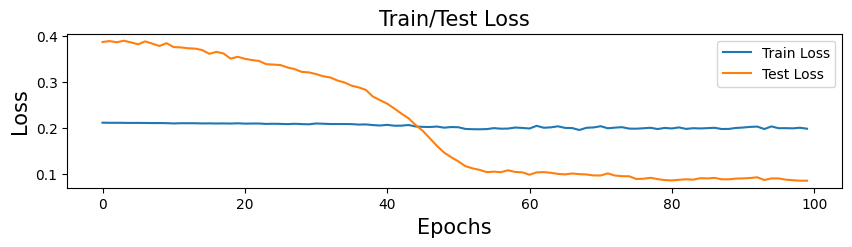

In [17]:
# Create the plot
fig, ax = plt.subplots(figsize=(10, 2))
ax.plot(train_total_loss, label='Train Loss')
ax.plot(test_total_loss, label='Test Loss')

# Set the x-axis label and title
ax.set_xlabel('Epochs', size=15)
ax.set_ylabel('Loss', size=15)
ax.set_title('Train/Test Loss', size=15)

# Display the plot
plt.legend()
plt.show()

## Plot Actual/Predicted stock price

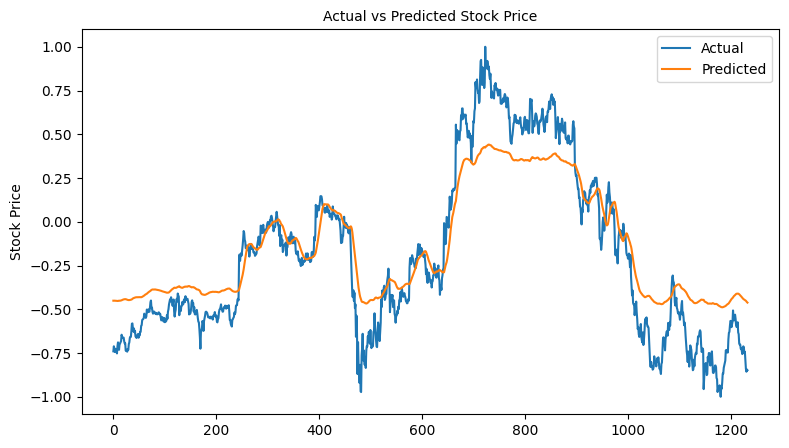

In [18]:
# Create the plot
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(acts, label='Actual')
ax.plot(preds, label='Predicted')

# Set the x-axis label and title
#ax.set_xlabel('Date', size=15)
ax.set_ylabel('Stock Price', size=10)
ax.set_title('Actual vs Predicted Stock Price', size=10)

# Display the plot
plt.legend()
plt.show()

# Forecast stock price

In [19]:
# Forecast with predicted dataset
def forecast(fo_stock_data, sequence_len, fo_days):

  stock_price_last_seq_values = np.append(fo_stock_data[-(sequence_len-1):].values, preds[-1]).reshape(-1,1)
  forecast_data = []

  for i in range(fo_days):

    stock_dataset_fo = Stock_Dataset(stock_price_last_seq_values, 16)
    stock_dataloader_fo = DataLoader(stock_dataset_fo, batch_size=16, drop_last=True)
    
    with torch.no_grad():
      acts_fo, preds_fo = predict(model, stock_dataloader_fo)

    stock_price_last_seq_values = np.append(stock_price_last_seq_values[-(sequence_len-1):], preds_fo[-1]).reshape(-1,1)
    forecast_data.append(preds_fo[-1])
    

  acts_fo_it = sc.inverse_transform(acts_fo.reshape(-1,1))
  preds_fo_it = sc.inverse_transform(preds_fo.reshape(-1,1))
  forecast_data_it = sc.inverse_transform(np.array(forecast_data).reshape(-1,1))
  forecast_data_it = np.append(([np.nan] * len(fo_stock_data)), forecast_data_it)

  return forecast_data_it

In [20]:
forecast_days = 90
sequence_len = 32

fo_price = forecast(stock_price, sequence_len, forecast_days)

# Plot forecast 

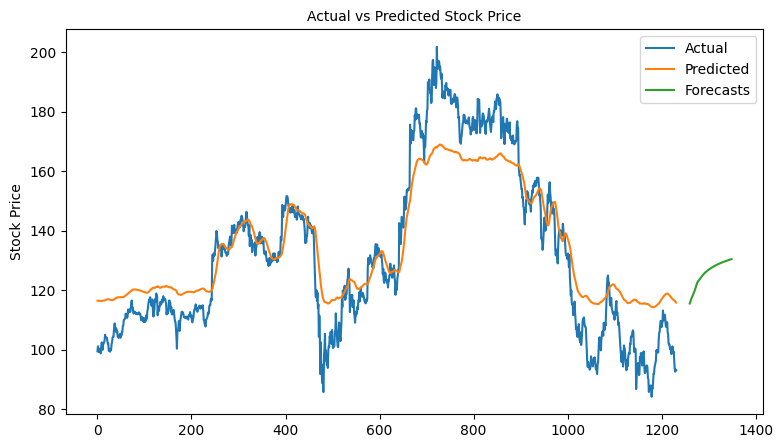

In [21]:
# Create the plot
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(acts_it, label='Actual')
ax.plot(preds_it, label='Predicted')
ax.plot(fo_price, label='Forecasts')

# Set the x-axis label and title
#ax.set_xlabel('Date', size=15)
ax.set_ylabel('Stock Price', size=10)
ax.set_title('Actual vs Predicted Stock Price', size=10)

# Display the plot
plt.legend()
plt.show()